# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Baseline Implementation**

This notebook contains the full implementation of **Spatial CNN-based Baseline** on the Chest X-ray Pneumonia dataset, for comparisons with **S³F-Net**. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR CHEST X-RAY)
# ==============================================================================
import os
import cv2
import zipfile
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
# Aspect ratio for 1600x1200 (4:3) scaled to a width of 512
IMG_SIZE = (384, 512)
BATCH_SIZE = 16
EPOCHS = 100
RANDOM_STATE = 42

# --- Paths ---
ZIP_PATH = "/content/drive/MyDrive/Medical Image Segmentation/chest_xray.zip"
TEMP_DATA_DIR = "/content/chest_xray_temp"

# Unzipping the data
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping dataset to local runtime... ---")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEMP_DATA_DIR)
    print("\n--- Unzipping complete! ---")
else:
    print("\n--- Dataset already unzipped. ---")

DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "chest_xray")
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)

--- Mounting Google Drive ---
Mounted at /content/drive

--- Unzipping dataset to local runtime... ---

--- Unzipping complete! ---


In [ ]:
# ==============================================================================
# 2. Data Loading (Adapted for the Chest-XRay Dataset structure)
# ==============================================================================

def load_xray_split(folder_path):
    """Loads images and labels from a folder with NORMAL/PNEUMONIA subdirectories."""
    images, labels = [], []
    # Ensuring PNEUMONIA is consistently mapped to 1 (the positive class)
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading data from: {folder_path} with classes {class_map}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    indices = np.arange(len(images))
    np.random.shuffle(indices)
    return np.array(images)[indices], np.array(labels)[indices], class_names

try:
    TRAIN_PATH = os.path.join(DATASET_BASE_PATH, "train")
    TEST_PATH = os.path.join(DATASET_BASE_PATH, "test")

    X_train, y_train, CLASS_NAMES = load_xray_split(TRAIN_PATH)
    X_test, y_test, _ = load_xray_split(TEST_PATH)

    X_val, y_val = X_test, y_test

    print("\n--- Data Loading Summary ---")
    print(f"Training set:   {len(X_train)} samples")
    print(f"Validation/Test set: {len(X_val)} samples")

    #Computing Class Weights to address imbalance in data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Calculated class weights: {class_weights_dict}")

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading data from: /content/chest_xray_temp/chest_xray/train with classes {'NORMAL': 0, 'PNEUMONIA': 1}
Loading data from: /content/chest_xray_temp/chest_xray/test with classes {'NORMAL': 0, 'PNEUMONIA': 1}

--- Data Loading Summary ---
Training set:   5232 samples
Validation/Test set: 624 samples
Calculated class weights: {0: np.float64(1.939214232765011), 1: np.float64(0.6737058975019315)}


## **Spatial CNN Baseline Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SPATIAL-ONLY Baseline FOR CHEST X-RAY)
# ==============================================================================
# This block defines the Spatial-Only baseline model, designed for a direct
# comparison with the S³F-Net architectures.

# --- Encoder Definition (Identical to the S³F-Net's spatial branch) ---
def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

# --- Spatial-Only Classifier Model Builder ---
def build_spatial_only_binary(input_shape):
    """Builds the classifier using only the spatial encoder and its head."""
    inputs = layers.Input(input_shape)

    # 1. Building Encoder
    features = build_spatial_encoder(inputs)

    # 2. Converting feature map to vector
    x = layers.GlobalAveragePooling2D()(features)

    # 3. Classifier Head (Matching the "Spatial Tower Head" from the S³F-Net)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # 4. Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="Spatial_Only_Binary_Classifier")

    # Compiling with the same optimizer and BCE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

print("Spatial-Only model architecture is ready for Chest X-Ray.")

Spatial-Only model architecture is ready for Chest X-Ray.


In [ ]:
# ===========================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ===========================================

# --- Binary F1 Score Callback ---
class BinaryF1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=15):
        super(BinaryF1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        logs['val_f1'] = f1
        print(f" - val_f1 (PNEUMONIA): {f1:.4f}", end="")
        if f1 > self.best_f1:
            print(f" (New best F1, saving model)")
            self.best_f1 = f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping.")
                self.model.stop_training = True

# --- Training ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "spatial_only_XRAY.keras")
print("\n--- Building Spatial-Only CNN Classifier for Chest X-Ray ---")
classifier_model_spatial = build_spatial_only_binary(X_train.shape[1:])
classifier_model_spatial.summary()

f1_callback_spatial = BinaryF1ScoreCallback(validation_data=(X_val, y_val), filepath=CLASSIFIER_MODEL_PATH, patience=20)
reduce_lr_spatial = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history_spatial = classifier_model_spatial.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback_spatial, reduce_lr_spatial]
)

print("\n--- Training Finished ---")


--- Building Spatial-Only Classifier for Chest X-Ray ---


Model: "Spatial_Only_Binary_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 384, 512, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 384, 512, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 384, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 384, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 192, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 192, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 192, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 192, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 96, 128, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 48, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 48, 64, 256)    │             

 Total params: 1,307,745 (4.99 MB)

 Trainable params: 1,305,761 (4.98 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/100
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7561 - loss: 0.4769 - val_f1 (PNEUMONIA): 0.7692 (New best F1, saving model)
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.7564 - loss: 0.4765 - val_accuracy: 0.6250 - val_loss: 1.3853 - val_f1: 0.7692 - learning_rate: 3.0000e-04
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8680 - loss: 0.3108 - val_f1 (PNEUMONIA): 0.3976
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8680 - loss: 0.3108 - val_accuracy: 0.5144 - val_loss: 3.0899 - val_f1: 0.3976 - learning_rate: 3.0000e-04
Epoch 3/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8956 - loss: 0.2513 - val_f1 (PNEUMONIA): 0.5961
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8956 - loss: 0.2513 - val_accuracy: 0.6330 - val_loss: 1.1456 - val_f1: 0.5961 - learning_rate: 3.0000e-04
Epoch 4/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9168 - loss: 0.2263 - val_f1 (PNEUMONIA): 0.7692
327/327 ━━━━



--- Final Evaluation on Chest X-Ray Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/spatial_only_XRAY_Repeat.keras

Test Loss: 0.3324
Test Accuracy: 0.8654
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step

--- Detailed Performance Metrics ---
F1 Score (Pneumonia): 0.8971
Cohen's Kappa: 0.7037
MCC: 0.7094
AUC-ROC: 0.9343

--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL     0.8788    0.7436    0.8056       234
   PNEUMONIA     0.8592    0.9385    0.8971       390

    accuracy                         0.8654       624
   macro avg     0.8690    0.8410    0.8513       624
weighted avg     0.8665    0.8654    0.8627       624


--- Confusion Matrix ---


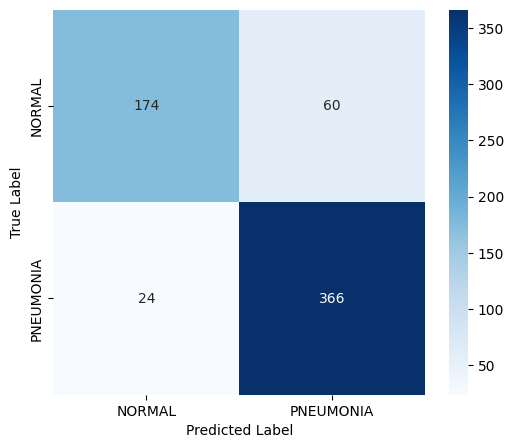


--- Training History Plots ---


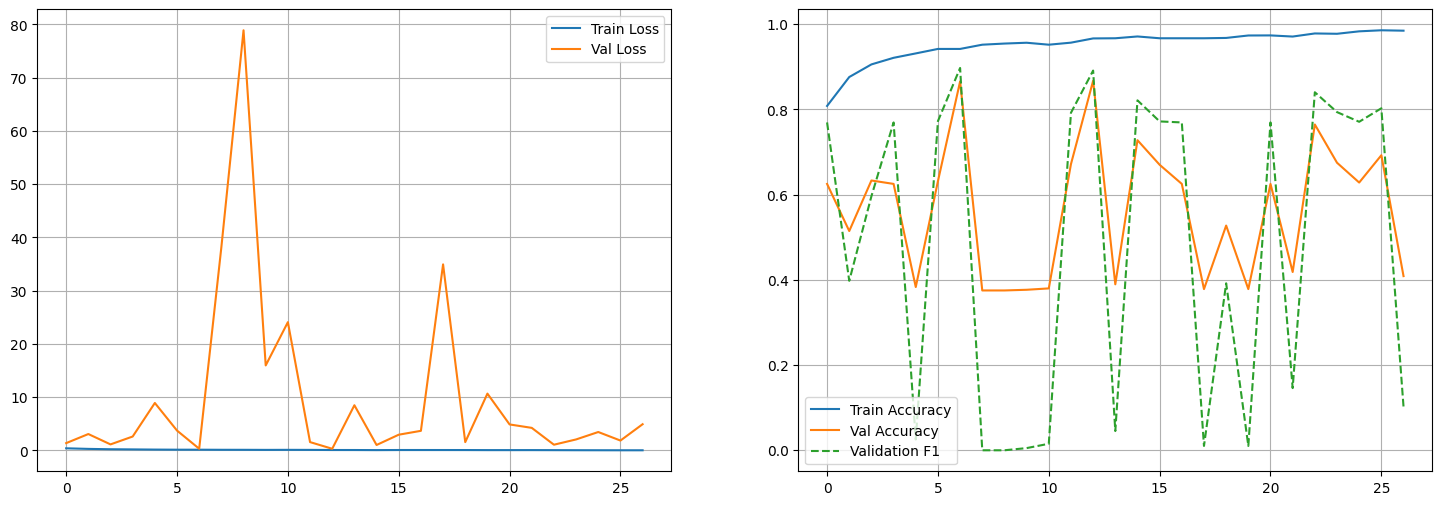


--- ROC Curve Analysis ---


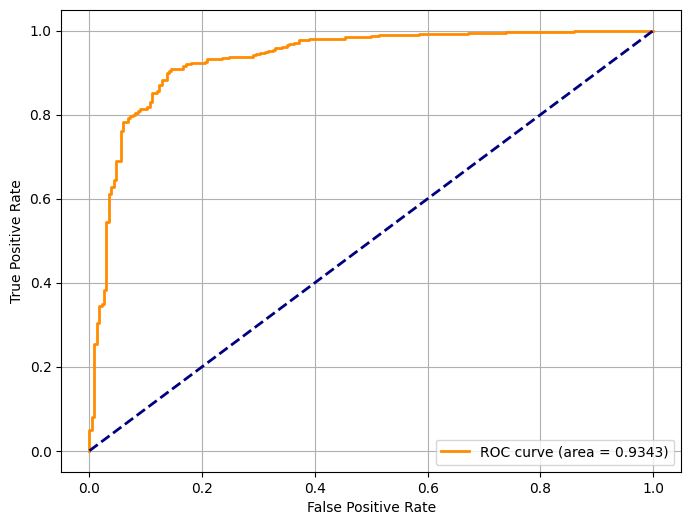

In [ ]:
# =============================
# BLOCK 5: EVALUATION
# =============================
print("\n\n--- Final Evaluation on Chest X-Ray Test Set ---")

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(CLASSIFIER_MODEL_PATH, custom_objects=custom_objects)

    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {loss:.4f}"); print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    print("\n--- Detailed Performance Metrics ---")
    f1_pneumonia = f1_score(y_test, y_pred_classes, pos_label=1)
    print(f"F1 Score (Pneumonia): {f1_pneumonia:.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_classes):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_classes):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred_classes);
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Spatial-CNN Baseline on Chest X-Ray (Test Set)');
    plt.show()

    if 'history_spatial' in locals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history_spatial.history['loss'], label='Train Loss')
        ax1.plot(history_spatial.history['val_loss'], label='Val Loss')
        # ax1.set_title('Model Loss');
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history_spatial.history['accuracy'], label='Train Accuracy')
        ax2.plot(history_spatial.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1' in history_spatial.history:
            ax2.plot(history_spatial.history['val_f1'], label='Validation F1', linestyle='--')
        # ax2.set_title('Model Performance');
        ax2.legend()
        ax2.grid(True)
        plt.show()

    print("\n--- ROC Curve Analysis ---")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")